In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')

/tmp/ipykernel_36121/2638831187.py:6: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data_csv = pd.read_csv('fr.openfoodfacts.org.products.csv', sep='\t')


In [2]:
#choix des variables
#
data_before_action = data_csv.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

# Liste des colonnes à conserver
variables_pertinentes = [
    'created_datetime','code', 'product_name', 'brands', 'categories', 'ingredients_text', 'additives_tags', 'nutrition_grade_fr',
    'energy_100g', 'proteins_100g', 'carbohydrates_100g', 'sugars_100g','fiber_100g','fat_100g', 'saturated-fat_100g',
    'alcohol_100g', 'countries_fr','potassium_100g','calcium_100g','vitamin-a_100g','vitamin-c_100g','vitamin-d_100g','cholesterol_100g','image_url'
]

start = time.time()
data = data_csv.drop([col for col in data_csv.columns if col not in variables_pertinentes], axis=1)
end = time.time()
print(f"Temps d'exécution de la méthode drop() : {end - start:.4f} secondes")

Le nombre de lignes data avant action est 320772
Temps d'exécution de la méthode drop() : 0.0362 secondes


In [3]:
# traitement des doublons

data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

duplicates = data[data.duplicated(subset=['code'], keep=False)]
print(f'Le nombre de doublons est {duplicates.shape[0]}')

most_recent_duplicates = duplicates.sort_values(by='created_datetime',ascending=False).drop_duplicates(subset=['code'])
data = data.drop(most_recent_duplicates.index, errors='ignore')

print(f'Le nombre de lignes data après suppression des doublons est {data.shape[0]}, {data_before_action - data.shape[0]} ont été supprimés')

Le nombre de lignes data avant action est 320772
Le nombre de doublons est 245
Le nombre de lignes data après suppression des doublons est 320660, 112 ont été supprimés


In [4]:
# traitement des valeurs manquantes ou aberrantes

data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#La variables  code et product_name sont obligatoires
empty_mandatory_variables = data[
    (data['product_name'].isna()) | ((data['code'].isna()))
]
print(f'Les individus avec un nom de produit ou code vides sont aux nombre de {len(empty_mandatory_variables)}')
data.drop(empty_mandatory_variables.index, inplace=True)

#les 7 lignes avec une valeur négative sont des erreurs de signe.
#Remplacement par la valeur absolue
print(f'Sugar négatifs remplacés par valeur absolue {data.loc[data["sugars_100g"] < 0, ["sugars_100g"]].shape[0]}')
print(f'Fibre négatifs remplacés par valeur absolue {data.loc[data["fiber_100g"] < 0, ["fiber_100g"]].shape[0]}')
print(f'Prot négatifs remplacés par valeur absolue {data.loc[data["proteins_100g"] < 0, ["proteins_100g"]].shape[0]}')
print(f'Vitamin a négatifs remplacés par valeur absolue {data.loc[data["vitamin-a_100g"] < 0, ["vitamin-a_100g"]].shape[0]}')
print(f'Vitamin c négatifs remplacés par valeur absolue {data.loc[data["vitamin-c_100g"] < 0, ["vitamin-c_100g"]].shape[0]}')
data.loc[data['sugars_100g'] < 0,'sugars_100g'] = data['sugars_100g'].abs()
data.loc[data['fiber_100g'] < 0,'fiber_100g'] = data['fiber_100g'].abs()
data.loc[data['proteins_100g'] < 0,'proteins_100g'] = data['proteins_100g'].abs()
data.loc[data['vitamin-a_100g'] < 0,'vitamin-a_100g'] = data['vitamin-a_100g'].abs()
data.loc[data['vitamin-c_100g'] < 0,'vitamin-c_100g'] = data['vitamin-c_100g'].abs()

#imputation par 0 pour les variables quantitatives manquantes
cols = ['potassium_100g','calcium_100g','vitamin-a_100g','vitamin-c_100g','vitamin-d_100g','cholesterol_100g','energy_100g', 'sugars_100g','fiber_100g', 'saturated-fat_100g', 'alcohol_100g','proteins_100g','fat_100g','carbohydrates_100g']
data[cols] = data[cols].fillna(0)

#imputation des protéines lipides et glucides par les sous-variables
print('SI possible imputation des sous-variables aux lipides et glucides manquants')
condition1 = data['fat_100g'].isnull()
condition2 = data['saturated-fat_100g'] > data['fat_100g']
data.loc[condition1 | condition2, 'fat_100g'] = data['saturated-fat_100g']

condition1 = data['carbohydrates_100g'].isnull()
condition2 = data['sugars_100g'] > data['carbohydrates_100g']
data.loc[condition1 | condition2, 'carbohydrates_100g'] = data['sugars_100g']

aberrants = data[
                 (data['sugars_100g'] > data['carbohydrates_100g']) |
                 ((data['carbohydrates_100g'] + data['proteins_100g'] + data['fat_100g']) > 100) |
                 (data['fiber_100g'] > 100) |
                 (data['vitamin-a_100g'] > 100) |
                 (data['vitamin-c_100g'] > 100) |
                 (data['vitamin-d_100g'] > 100) |
                 (data['potassium_100g'] > 100) |
                 (data['calcium_100g'] > 100)
]

print(f'Les valeurs aberrantes sont aux nombres de {len(aberrants)}')

# #suppression des valeurs aberrantes
data.drop(aberrants.index, inplace=True)

Le nombre de lignes data avant action est 320660
Les individus avec un nom de produit ou code vides sont aux nombre de 17780
Sugar négatifs remplacés par valeur absolue 7
Fibre négatifs remplacés par valeur absolue 1
Prot négatifs remplacés par valeur absolue 3
Vitamin a négatifs remplacés par valeur absolue 1
Vitamin c négatifs remplacés par valeur absolue 1
SI possible imputation des sous-variables aux lipides et glucides manquants
Les valeurs aberrantes sont aux nombres de 1847


Le nombre de lignes data avant action est 301033
<function show at 0x7f011a04caf0>


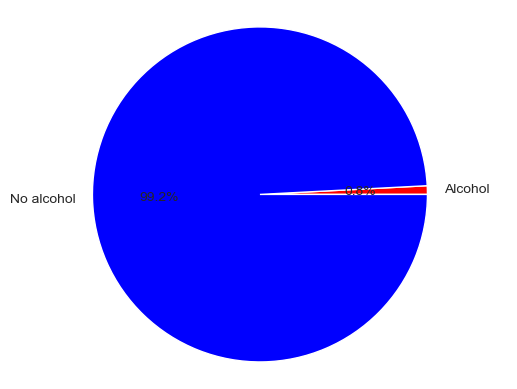

In [5]:
#supression de l'alcool

data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

#Les produits contenant de l'alcool sont à bannir
data_alcohol = data[data['alcohol_100g'] > 0]
data_no_alcohol = data[data['alcohol_100g'] == 0]
percent_alcohol = len(data_alcohol) / len(data)
percent_no_alcohol = len(data_no_alcohol) / len(data)
labels = ['Alcohol', 'No alcohol']
sizes = [percent_alcohol, percent_no_alcohol]
colors = ['red', 'blue']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
ax.axis('equal')
print(plt.show)
indices_to_drop = data[data['alcohol_100g'] > 0].index
data = data.drop(indices_to_drop)

Le nombre de lignes data avant action est 298534
36332 produits ont été retirés


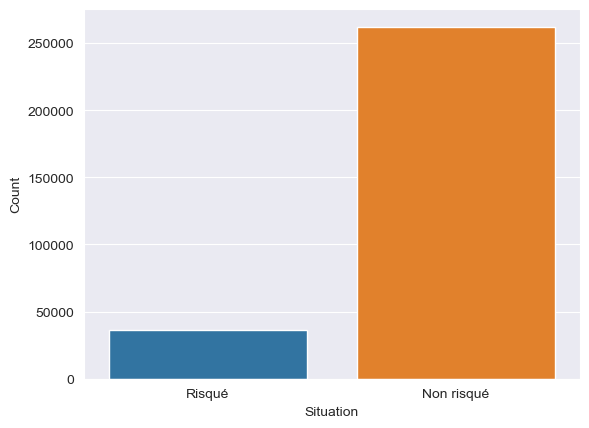

In [6]:
# supression des mauvais additifs

data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

data.loc[data['additives_tags'].isnull(), 'additives_tags'] = ''
risky_additives = ['E250', 'E450', 'E202', 'E407', 'E252', 'E621', 'E224', 'E211', 'E482', 'E249', 'E212', 'E343',
                   'E1102', 'E511', 'E155']
risky_additives_regex = '|'.join(risky_additives)  # join the elements of the list with `|`
data['additives_tags_clean'] = data['additives_tags'].str.replace('en:', '')

# print(data.loc[40:55, 'additives_tags_clean'])
data['risky'] = 'non'
risky = data[data['additives_tags_clean'].str.contains(risky_additives_regex, case=False)]
data.loc[risky.index, 'risky'] = 'oui'

risky_count = len(data[data['risky'] == 'oui'])
non_risky_count = len(data[data['risky'] == 'non'])
# Créer un dataframe avec les données à afficher dans le graphique
risky_frame = pd.DataFrame({'Situation': ['Risqué', 'Non risqué'], 'Count': [risky_count, non_risky_count]})
sns.barplot(x='Situation', y='Count', data=risky_frame)

#retirer les aliments risqué
print(f'{risky_count} produits ont été retirés')
data.drop(data[data['risky'] == 'oui'].index, inplace=True)


In [7]:
# Recalcul des valeurs énergétiques et suppression des données aberrantes

data_before_action = data.shape[0]
print(f'Le nombre de lignes data avant action est {data_before_action}')

kcal_prot = 4
kcal_glucide = 4
kcal_lipide = 9
data['kcal'] = (data['proteins_100g'] * kcal_prot + data['carbohydrates_100g'] * kcal_glucide + data['fat_100g'] * kcal_lipide)
# #Suppression des valeurs énergétiques <= 0 ou > 900
mask = ((data['kcal'] <= 0) | (data['kcal'] > 900 ))
print(f'Les lignes <= 0 sont au nombre de {(data["kcal"] <= 0).sum()}')
print(f'Les lignes > 900 sont au nombre de {(data["kcal"] > 900).sum()}')
data.drop(data[mask].index, inplace=True)


Le nombre de lignes data avant action est 262202
Les lignes <= 0 sont au nombre de 47831
Les lignes > 900 sont au nombre de 0


In [8]:
# calculer le nutriscore pour les valeurs vides (en moyenne)
def calcul_nutriscore(line):
    A = -0.6 #moyenne des possibilités
    B = 3
    C = 2
    D = 1
    E = 0.35 #moyenne des possibilités
    nutriscore = (A * (2 * line['kcal'] / 100) + B * (line['sugars_100g'] / 100) + C * (line['saturated-fat_100g'] / 100) - D * (line['fiber_100g'] / 100) - E * (line['proteins_100g'] / 100))
    if nutriscore < -2:
        nutriscore_letter = 'a'
    elif nutriscore < -1:
        nutriscore_letter = 'b'
    elif nutriscore < 1:
        nutriscore_letter = 'c'
    elif nutriscore < 3:
        nutriscore_letter = 'd'
    else:
        nutriscore_letter = 'e'
    return  nutriscore_letter


data.loc[(data['nutrition_grade_fr'].isna()), 'nutrition_grade_fr'] = data.loc[(data['nutrition_grade_fr'].isna()), ['kcal','sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'proteins_100g']].apply(calcul_nutriscore, axis=1)

In [9]:
print(f'Fin du nettoyage: il reste {data.shape[0]} produits')
data.to_csv('cleaned_data.csv', index=False)

Fin du nettoyage: il reste 214371 produits
